Segment strategies designing and implementation

In [1]:
#Imports & Load Model
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load trained multilabel model
model = load_model("/content/drive/MyDrive/multilabel_cnn_improved.keras")

In [2]:
# SEGMENTATION PARAMETERS
SR = 16000
SEGMENT_DURATION = 2.0      # seconds
HOP_DURATION = 1.0          # seconds (50% overlap)

SEGMENT_SAMPLES = int(SEGMENT_DURATION * SR)
HOP_SAMPLES = int(HOP_DURATION * SR)

# Spectrogram parameters (same as training)
N_MELS = 128
HOP_LENGTH = 512
IMG_SIZE = 128

# Energy threshold to remove silent segments
ENERGY_THRESHOLD = 1e-4

In [3]:
# AUDIO SEGMENTATION
def segment_audio(audio, sr, segment_samples, hop_samples, energy_threshold):
    segments = []
    for start in range(0, len(audio) - segment_samples + 1, hop_samples):
        segment = audio[start:start + segment_samples]

        # Skip silent / low-energy segments
        if np.mean(segment ** 2) < energy_threshold:
            continue

        segments.append(segment)

    return segments

In [4]:
# SEGMENT → MEL SPECTROGRAM
def segment_to_mel(segment, sr):
    mel = librosa.feature.melspectrogram(
        y=segment,
        sr=sr,
        n_mels=N_MELS,
        hop_length=HOP_LENGTH
    )

    mel_db = librosa.power_to_db(mel, ref=np.max)

    # Resize to CNN input size
    mel_db = tf.image.resize(
        mel_db[..., np.newaxis],
        (IMG_SIZE, IMG_SIZE)
    ).numpy()

    # Convert to 3 channels
    mel_db = np.repeat(mel_db, 3, axis=-1)

    # Normalize
    mel_db = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min() + 1e-6)

    return mel_db

In [5]:
# SEGMENT-WISE PREDICTION
def predict_segments(audio_path, threshold=0.5):
    audio, sr = librosa.load(audio_path, sr=SR, mono=True)

    segments = segment_audio(
        audio,
        sr,
        SEGMENT_SAMPLES,
        HOP_SAMPLES,
        ENERGY_THRESHOLD
    )

    predictions = []
    for i, seg in enumerate(segments):
        mel_img = segment_to_mel(seg, sr)
        mel_img = np.expand_dims(mel_img, axis=0)

        probs = model.predict(mel_img, verbose=0)[0]
        preds = (probs >= threshold).astype(int)

        predictions.append((i, probs, preds))

    return segments, predictions

In [9]:
# INSPECT SEGMENTS
TEST_AUDIO = "/content/drive/MyDrive/irmas_multilabel_audio/mix_0.wav"

segments, predictions = predict_segments(TEST_AUDIO)
print(f"Total valid segments after silence filtering: {len(segments)}")

# Print predictions for first 5 segments
NUM_SEGMENTS_TO_INSPECT = 5

for i, probs, preds in predictions[:NUM_SEGMENTS_TO_INSPECT]:
    print(f"Segment {i}")
    print("Probabilities:", np.round(probs, 3))
    print("Predicted labels:", preds)
    print("-" * 40)

Total valid segments after silence filtering: 3
Segment 0
Probabilities: [0.041 0.057 0.072 0.029 0.073 0.019 0.052 0.474 0.752 0.082 0.011]
Predicted labels: [0 0 0 0 0 0 0 0 1 0 0]
----------------------------------------
Segment 1
Probabilities: [0.048 0.056 0.081 0.035 0.089 0.017 0.059 0.48  0.714 0.089 0.015]
Predicted labels: [0 0 0 0 0 0 0 0 1 0 0]
----------------------------------------
Segment 2
Probabilities: [0.059 0.141 0.12  0.071 0.043 0.055 0.112 0.431 0.866 0.13  0.014]
Predicted labels: [0 0 0 0 0 0 0 0 1 0 0]
----------------------------------------


In [10]:
# VISUALIZE SEGMENTS
def visualize_segment(segment, sr, idx):
    mel = librosa.feature.melspectrogram(
        y=segment,
        sr=sr,
        n_mels=N_MELS,
        hop_length=HOP_LENGTH
    )
    mel_db = librosa.power_to_db(mel, ref=np.max)

    plt.figure(figsize=(4, 3))
    librosa.display.specshow(
        mel_db,
        sr=sr,
        hop_length=HOP_LENGTH,
        cmap="magma"
    )
    plt.title(f"Segment {idx} Mel-Spectrogram")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

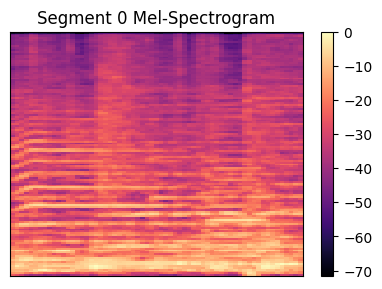

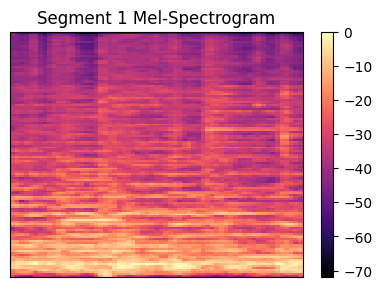

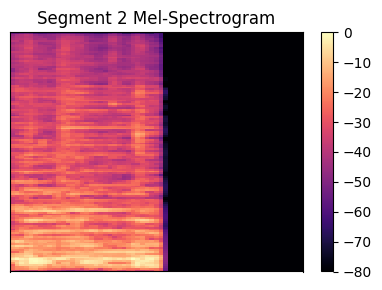

In [11]:
# Visual inspection of first 5 VALID segments
for i in range(min(NUM_SEGMENTS_TO_INSPECT, len(segments))):
    visualize_segment(segments[i], SR, i)

# **Conclusion**

A fixed-length overlapping segmentation strategy was applied to analyze the temporal behavior of the multilabel instrument recognition model. Due to silence and low-energy regions at the boundaries of the audio, only three valid segments were retained after energy-based filtering. Segment-wise inspection showed consistent instrument predictions across these segments, indicating stable and robust temporal performance of the model.